In [1]:
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def get_image_paths(folder_path):
    # Get a list of all files in the folder
    files = os.listdir(folder_path)
    
    # Filter only for image files (you can add more extensions if needed)
    image_files = [os.path.join(folder_path, f) for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')) and not f.startswith('.')]
    image_names = [os.path.splitext(f)[0] for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', 'gif')) and not f.startswith('.')]
    if not image_files:
        print(f"No image files found in {folder_path}")
    
    return image_files, image_names

def display_images_in_jupyter(image_paths, columns=2):
    if not image_paths:
        print("No images to display.")
        return
    
    total_images = len(image_paths)
    rows = -(-total_images // columns)  # Calculate number of rows needed
    
    # Create a grid to display images
    fig, axes = plt.subplots(rows, columns, figsize=(12, 8))
    axes = axes.flatten()
    
    for i, image_path in enumerate(image_paths):
        if i >= total_images:
            break
        
        image = Image.open(image_path)
        axes[i].imshow(image)
        axes[i].axis('off')
    
    # Remove empty subplots
    for i in range(total_images, rows * columns):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.show()

In [2]:
dev_folder_path = "./devset_images/devset_images/"
test_folder_path = "./testset_images/testset_images/"
dev_image_paths = get_image_paths(dev_folder_path)[0]
test_image_paths = get_image_paths(test_folder_path)[0]
print(len(dev_image_paths))
print(len(test_image_paths))

5280
1320


In [3]:
def list_file_extensions(folder_path):
    return list({os.path.splitext(file)[1].lower() for root, dirs, files in os.walk(folder_path) for file in files})

print(list_file_extensions(dev_folder_path))

['.jpg', '.png', '.gif']


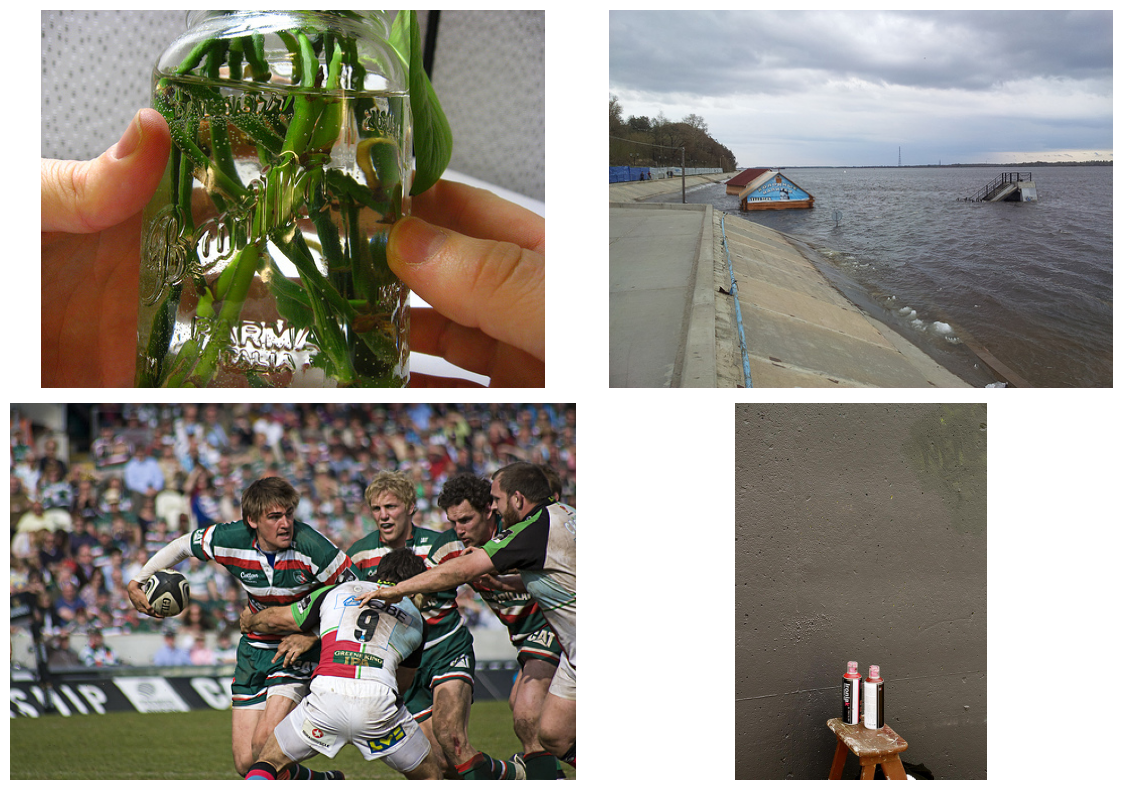

In [4]:
display_images_in_jupyter(dev_image_paths[0:4], columns=2)

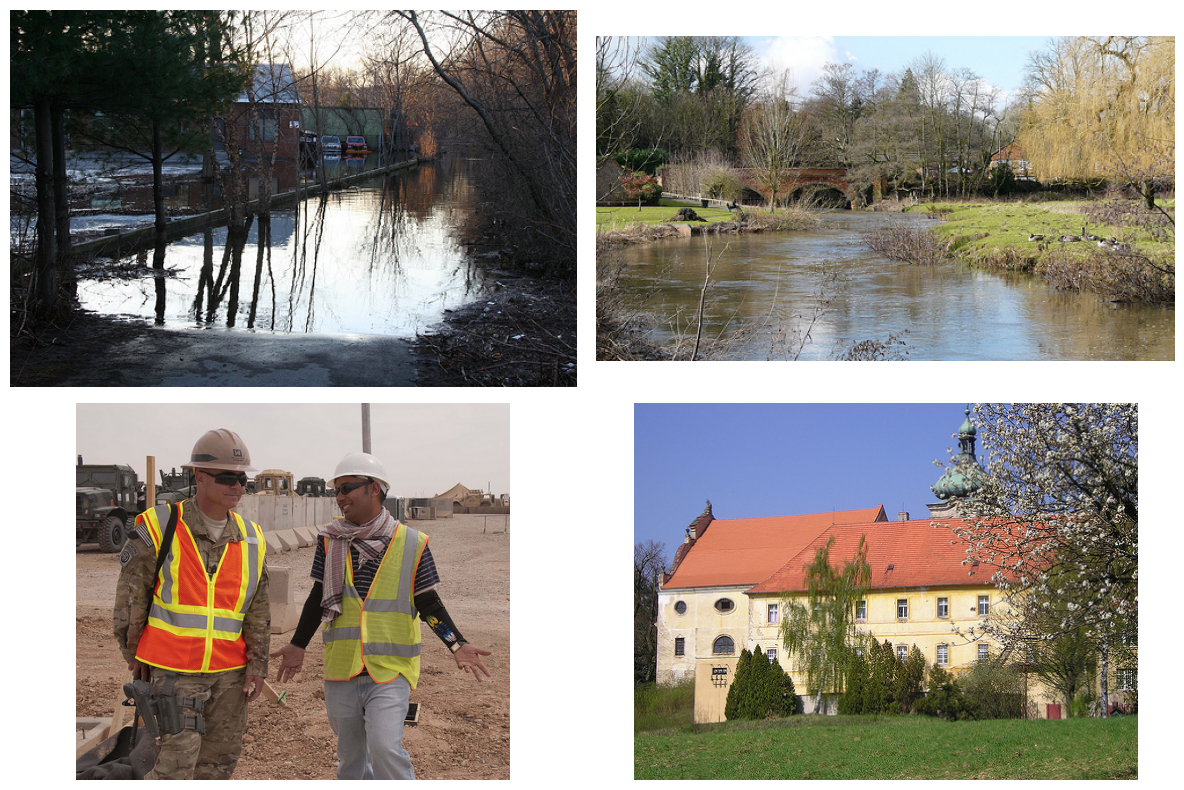

In [5]:
display_images_in_jupyter(test_image_paths[0:4], columns=2)

In [6]:
def images_to_numpy_array(image_paths, target_size=(224, 224)):
    return [np.array(Image.open(image_path).resize(target_size)) for image_path in image_paths]
dev_image_arrays = images_to_numpy_array(dev_image_paths)
test_image_arrays = images_to_numpy_array(test_image_paths)

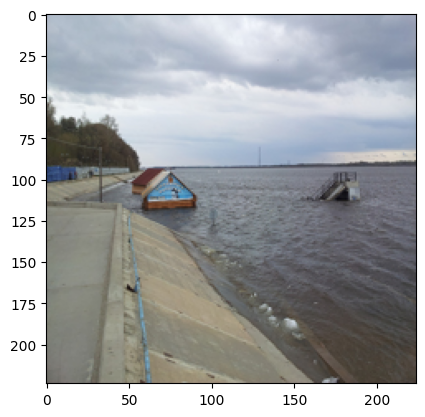

In [7]:
plt.imshow(dev_image_arrays[1])

In [8]:
from collections import Counter

# Flatten the list of shapes
dev_shapes = [tuple(arr.shape) for arr in dev_image_arrays]
test_shapes = [tuple(arr.shape) for arr in test_image_arrays]

In [9]:
dev_shape_counter = Counter(dev_shapes)
dev_shape_counter

Counter({(224, 224, 3): 5280})

In [10]:
test_shape_counter = Counter(test_shapes)
test_shape_counter.most_common(1)

[((224, 224, 3), 1320)]

In [11]:
dev_df = pd.read_csv("./devset_images_gt.csv")
sorted_df = dev_df.sort_values(by="id")
array_sorted_df = np.array(sorted_df["id"])
array_sorted_df, array_sorted_df.shape

(array([     224249,      228743,      473932, ..., 13948706965,
        13989148346, 14006803563]),
 (5280,))

In [12]:
dev_image_names = np.array(get_image_paths(dev_folder_path)[1], dtype="int64")
test_image_names = np.array(get_image_paths(test_folder_path)[1], dtype="int64")
dev_image_names, dev_image_names.shape

(array([ 2163909943, 10706899626,  4560503887, ...,  2239410796,
        10144679576,  5548355626]),
 (5280,))

In [13]:
all(np.sort(dev_image_names) == array_sorted_df)

True

In [14]:
dev_image_vectors = [image.reshape(-1) for image in dev_image_arrays]

In [15]:
dict1 = dict(zip(dev_image_names, dev_image_vectors))

In [16]:
dict2 = dev_df.set_index('id')['label'].to_dict()

In [17]:
merged_dict = {k: (v, dict2[k]) for k, v in dict1.items() if k in dict2}
X_train = np.array([item[0] for item in merged_dict.values()]).astype("float32")
Y_train = np.array([item[1] for item in merged_dict.values()]).reshape(-1,).astype("float32")

In [18]:
X_train.shape, Y_train.shape

((5280, 150528), (5280,))

# Normalize datasets

In [19]:
from scipy.stats import zscore

In [20]:
# Assuming X_train is a list of images
for i in range(len(X_train)):
    X_train[i] = zscore(X_train[i], axis=0)

In [21]:
X_train, Y_train

(array([[ 1.0140755 ,  0.9337788 ,  1.0461942 , ..., -0.23855296,
         -0.9933419 , -1.2502913 ],
        [ 0.5755819 ,  0.6541922 ,  0.9882861 , ..., -1.5075915 ,
         -1.7041172 , -1.8220327 ],
        [-0.5081615 , -0.42091334, -0.3860141 , ...,  0.08512577,
         -0.08937048, -0.4558126 ],
        ...,
        [-1.4166037 , -1.4014761 , -1.4922416 , ..., -0.47869414,
         -0.14588751, -0.16101508],
        [-0.0063282 ,  0.20763125,  0.5357024 , ..., -1.5040443 ,
         -1.5183083 , -1.5468363 ],
        [ 1.1041569 ,  1.2373384 ,  1.2639748 , ..., -1.0267487 ,
         -0.96015793, -0.8536126 ]], dtype=float32),
 array([0., 1., 0., ..., 1., 0., 0.], dtype=float32))

# Gradient descent

In [22]:
# GRADED FUNCTION: update_parameters_with_gd

def update_parameters_with_gd(parameters, grads, learning_rate):
    """
    Update parameters using one step of gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters to be updated:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients to update each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    learning_rate -- the learning rate, scalar.
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """
    L = len(parameters) // 2 # number of layers in the neural networks

    # Update rule for each parameter
    for l in range(1, L + 1):
        # (approx. 2 lines)
        parameters["W" + str(l)] -=  learning_rate * grads["dW" + str(l)]
        parameters["b" + str(l)] -=  learning_rate * grads["db" + str(l)]
        # YOUR CODE STARTS HERE
        
        
        # YOUR CODE ENDS HERE
    return parameters

## Random minibatch

In [23]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    mini_batch_size -- size of the mini-batches, integer
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    np.random.seed(seed)            # To make your "random" minibatches the same as ours
    m = X.shape[1]                  # number of training examples
    mini_batches = []
        
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1, m))
    
    inc = mini_batch_size

    # Step 2 - Partition (shuffled_X, shuffled_Y).
    # Cases with a complete mini batch size only i.e each of 64 examples.
    num_complete_minibatches = np.floor(m / mini_batch_size).astype("int64")# number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        # (approx. 2 lines)
        mini_batch_X = shuffled_X[:, k * mini_batch_size: (k+1) * mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size: (k+1) * mini_batch_size]
        # YOUR CODE STARTS HERE
        
        
        # YOUR CODE ENDS HERE
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # For handling the end case (last mini-batch < mini_batch_size i.e less than 64)
    if m % mini_batch_size != 0:
        #(approx. 2 lines)
        mini_batch_X = shuffled_X[:, -(m - mini_batch_size * num_complete_minibatches):]
        mini_batch_Y = shuffled_Y[:, -(m - mini_batch_size * num_complete_minibatches):]
        # YOUR CODE STARTS HERE
        
        
        # YOUR CODE ENDS HERE
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [24]:
from sklearn.model_selection import train_test_split

X_train1, X_test1, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.05, random_state=42)

In [25]:
print(f"X_train size: {X_train1.shape}")
print(f"y_train size: {y_train.shape}")
print(f"X_test size: {X_test1.shape}")
print(f"y_test size: {y_test.shape}")

X_train size: (5016, 150528)
y_train size: (5016,)
X_test size: (264, 150528)
y_test size: (264,)


In [26]:
y_train1 = y_train.reshape(1, -1)
np.random.seed(1)
mini_batch_size = 64
mini_batches = random_mini_batches(X_train1.T, y_train1, mini_batch_size)
n_batches = len(mini_batches)

In [27]:
print ("shape of the 1st mini_batch_X: " + str(mini_batches[-3][0].shape))
print ("shape of the 2nd mini_batch_X: " + str(mini_batches[-2][0].shape))
print ("shape of the 3rd mini_batch_X: " + str(mini_batches[-1][0].shape))
print ("shape of the 1st mini_batch_Y: " + str(mini_batches[-3][1].shape))
print ("shape of the 2nd mini_batch_Y: " + str(mini_batches[-2][1].shape)) 
print ("shape of the 3rd mini_batch_Y: " + str(mini_batches[-1][1].shape))
print ("mini batch sanity check: " + str(mini_batches[0][0][0][0:3]))

shape of the 1st mini_batch_X: (150528, 64)
shape of the 2nd mini_batch_X: (150528, 64)
shape of the 3rd mini_batch_X: (150528, 24)
shape of the 1st mini_batch_Y: (1, 64)
shape of the 2nd mini_batch_Y: (1, 64)
shape of the 3rd mini_batch_Y: (1, 24)
mini batch sanity check: [ 1.3026615 -1.3923944  1.3116533]


# Momentum

In [28]:
def initialize_velocity(parameters):
    """
    Initializes the velocity as a python dictionary with:
                - keys: "dW1", "db1", ..., "dWL", "dbL" 
                - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.
    Arguments:
    parameters -- python dictionary containing your parameters.
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    
    Returns:
    v -- python dictionary containing the current velocity.
                    v['dW' + str(l)] = velocity of dWl
                    v['db' + str(l)] = velocity of dbl
    """
    
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    
    # Initialize velocity
    for l in range(1, L + 1):
        v["dW" + str(l)] = np.zeros(parameters["W" + str(l)].shape)
        v["db" + str(l)] = np.zeros(parameters["b" + str(l)].shape)  
    return v

In [29]:
def update_parameters_with_momentum(parameters, grads, v, beta, learning_rate):
    """
    Update parameters using Momentum
    
    Arguments:
    parameters -- python dictionary containing your parameters:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients for each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    v -- python dictionary containing the current velocity:
                    v['dW' + str(l)] = ...
                    v['db' + str(l)] = ...
    beta -- the momentum hyperparameter, scalar
    learning_rate -- the learning rate, scalar
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    v -- python dictionary containing your updated velocities
    """

    L = len(parameters) // 2 # number of layers in the neural networks
    
    # Momentum update for each parameter
    for l in range(1, L + 1):
        
        # (approx. 4 lines)
        # compute velocities
        v["dW" + str(l)] = beta * v["dW" + str(l)] + (1 - beta) * grads["dW" + str(l)]
        v["db" + str(l)] = beta * v["db" + str(l)] + (1 - beta) * grads["db" + str(l)]
        # update parameters
        parameters["W" + str(l)] -= learning_rate * v["dW" + str(l)]
        parameters["b" + str(l)] -= learning_rate * v["db" + str(l)]
        # YOUR CODE STARTS HERE
        
        
        # YOUR CODE ENDS HERE
        
    return parameters, v

In [30]:
# GRADED FUNCTION: initialize_adam

def initialize_adam(parameters) :
    """
    Initializes v and s as two python dictionaries with:
                - keys: "dW1", "db1", ..., "dWL", "dbL" 
                - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.
    
    Arguments:
    parameters -- python dictionary containing your parameters.
                    parameters["W" + str(l)] = Wl
                    parameters["b" + str(l)] = bl
    
    Returns: 
    v -- python dictionary that will contain the exponentially weighted average of the gradient. Initialized with zeros.
                    v["dW" + str(l)] = ...
                    v["db" + str(l)] = ...
    s -- python dictionary that will contain the exponentially weighted average of the squared gradient. Initialized with zeros.
                    s["dW" + str(l)] = ...
                    s["db" + str(l)] = ...

    """
    
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    s = {}
    
    for l in range(1, L + 1):
        v["dW" + str(l)] = np.zeros(parameters["W" + str(l)].shape)
        v["db" + str(l)] = np.zeros(parameters["b" + str(l)].shape)
        s["dW" + str(l)] = np.zeros(parameters["W" + str(l)].shape)
        s["db" + str(l)] = np.zeros(parameters["b" + str(l)].shape)
    return v, s

In [31]:
# GRADED FUNCTION: update_parameters_with_adam

def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate = 0.01,
                                beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):
    """
    Update parameters using Adam
    
    Arguments:
    parameters -- python dictionary containing your parameters:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients for each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    t -- Adam variable, counts the number of taken steps
    learning_rate -- the learning rate, scalar.
    beta1 -- Exponential decay hyperparameter for the first moment estimates 
    beta2 -- Exponential decay hyperparameter for the second moment estimates 
    epsilon -- hyperparameter preventing division by zero in Adam updates

    Returns:
    parameters -- python dictionary containing your updated parameters 
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    """
    
    L = len(parameters) // 2                 # number of layers in the neural networks
    v_corrected = {}                         # Initializing first moment estimate, python dictionary
    s_corrected = {}                         # Initializing second moment estimate, python dictionary
    
    # Perform Adam update on all parameters
    for l in range(1, L + 1):
        v["dW" + str(l)] = beta1 * v["dW" + str(l)] + (1 - beta1) * grads["dW" + str(l)]
        v["db" + str(l)] = beta1 * v["db" + str(l)] + (1 - beta1) * grads["db" + str(l)]

        v_corrected["dW" + str(l)] = v["dW" + str(l)] / (1 - (beta1 ** t))
        v_corrected["db" + str(l)] = v["db" + str(l)] / (1 - (beta1 ** t))

        s["dW" + str(l)] = beta2 * s["dW" + str(l)] + (1 - beta2) * (grads["dW" + str(l)] ** 2)
        s["db" + str(l)] = beta2 * s["db" + str(l)] + (1 - beta2) * (grads["db" + str(l)] ** 2)

        s_corrected["dW" + str(l)] = s["dW" + str(l)] / (1 - (beta2 ** t))
        s_corrected["db" + str(l)] = s["db" + str(l)] / (1 - (beta2 ** t))
        
        parameters["W" + str(l)] -= learning_rate * v_corrected["dW" + str(l)] / (np.sqrt(s_corrected["dW" + str(l)]) + epsilon)
        parameters["b" + str(l)] -= learning_rate * v_corrected["db" + str(l)] / (np.sqrt(s_corrected["db" + str(l)]) + epsilon)
    return parameters, v, s, v_corrected, s_corrected

In [36]:
def model(X, Y, layers_dims, optimizer, learning_rate = 0.0007, mini_batch_size = 64, beta = 0.9,
          beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, num_epochs = 5000, print_cost = True):
    """
    3-layer neural network model which can be run in different optimizer modes.
    
    Arguments:
    X -- input data, of shape (2, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    optimizer -- the optimizer to be passed, gradient descent, momentum or adam
    layers_dims -- python list, containing the size of each layer
    learning_rate -- the learning rate, scalar.
    mini_batch_size -- the size of a mini batch
    beta -- Momentum hyperparameter
    beta1 -- Exponential decay hyperparameter for the past gradients estimates 
    beta2 -- Exponential decay hyperparameter for the past squared gradients estimates 
    epsilon -- hyperparameter preventing division by zero in Adam updates
    num_epochs -- number of epochs
    print_cost -- True to print the cost every 1000 epochs

    Returns:
    parameters -- python dictionary containing your updated parameters 
    """

    L = len(layers_dims)             # number of layers in the neural networks
    costs = []                       # to keep track of the cost
    t = 0                            # initializing the counter required for Adam update
    seed = 10                        # For grading purposes, so that your "random" minibatches are the same as ours
    m = X.shape[1]                   # number of training examples
    
    # Initialize parameters
    parameters = initialize_parameters(layers_dims)

    # Initialize the optimizer
    if optimizer == "gd":
        pass # no initialization required for gradient descent
    elif optimizer == "momentum":
        v = initialize_velocity(parameters)
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)
    
    # Optimization loop
    for i in range(num_epochs):
        
        # Define the random minibatches. We increment the seed to reshuffle differently the dataset after each epoch
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)
        cost_total = 0
        
        for minibatch in minibatches:

            # Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch

            # Forward propagation
            a3, caches = forward_propagation(minibatch_X, parameters)

            # Compute cost and add to the cost total
            cost_total += compute_cost(a3, minibatch_Y)

            # Backward propagation
            grads = backward_propagation(minibatch_X, minibatch_Y, caches)

            # Update parameters
            if optimizer == "gd":
                parameters = update_parameters_with_gd(parameters, grads, learning_rate)
            elif optimizer == "momentum":
                parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
            elif optimizer == "adam":
                t = t + 1 # Adam counter
                parameters, v, s, _, _ = update_parameters_with_adam(parameters, grads, v, s,
                                                               t, learning_rate, beta1, beta2,  epsilon)
        cost_avg = cost_total / m
        
        # Print the cost every 1000 epoch
        if print_cost and i % 1 == 0:
            print ("Cost after epoch %i: %f" %(i, cost_avg))
        if print_cost and i % 100 == 0:
            costs.append(cost_avg)
                
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

In [37]:
from opt_utils_v1a import load_params_and_grads, initialize_parameters, forward_propagation, backward_propagation
from opt_utils_v1a import compute_cost, predict, predict_dec, plot_decision_boundary, load_dataset

In [38]:
X_train1.T.shape[0]

150528

In [ ]:
# train 3-layer model
layers_dims = [X_train1.T.shape[0], 5, 2, 1]
parameters = model(X_train1.T, y_train1, layers_dims, optimizer = "gd")

# Predict
predictions = predict(X_train1.T, y_train1, parameters)

Cost after epoch 0: 0.610930
Cost after epoch 1: 0.566365
Cost after epoch 2: 0.548873
Cost after epoch 3: 0.537797
Cost after epoch 4: 0.526691
Cost after epoch 5: 0.516277
Cost after epoch 6: 0.509519
Cost after epoch 7: 0.503056
Cost after epoch 8: 0.495934
Cost after epoch 9: 0.489389
Cost after epoch 10: 0.484075
Cost after epoch 11: 0.477287
